In [1]:
# Importing packages
import gdal
import pandas as pd
import numpy as np
import geopandas as gpd
from io import StringIO
from shapely.geometry import Point
from osgeo import gdal
import osr
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import seaborn as sns
import os
import sys
sys.path.insert(0, os.path.abspath(''))
import rasterio
from rasterio.merge import merge
import h5py

from rasterio.plot import show

import glob



import data_processing_helper as dp
import practical_functions as pf
import xarray as xr
import pygrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import requests as rq
import shapely
from shapely.wkt import loads
import geoplot as gplt
import glob

plt.style.use('ggplot') # use ggplot style

/home/lavinia/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
df_env = pd.read_csv("../Data/Environmental_data/df_env_merged.csv")
# Make geodataframe
df_env['geometry'] = df_env['geometry'].apply(loads)
df_env = pf.make_geo_frame(df_env)
df_env['surveydate'] = pd.to_datetime(df_env['surveydate'], format='%Y-%m')
df_env["year"] = df_env["surveydate"].dt.year
df_env['surveydate'] = df_env['surveydate'].dt.strftime('%Y-%m')

### Shape files

In [4]:
gdf_AUS = gpd.read_file('../Data/Reefs/shp_GBR/Reefs_GBR.shp')
gdf_IND = gpd.read_file('../Data/Reefs/shp_indonesia/indonesia.shp')
gdf_TLS = gpd.read_file('../Data/Reefs/shp_timorleste/timorleste.shp')
gdf_SLB = gpd.read_file('../Data/Reefs/shp_solomon/solomon.shp')

# Combining the shapefiles
gdf_PAC = gpd.GeoDataFrame(pd.concat([gdf_AUS, gdf_IND, gdf_TLS, gdf_SLB]))

In [5]:
df_fishing = pd.read_csv("../Data/Anthropological_data/Fishing/fishing-vessels-v2.csv")

In [6]:
print("You have ",(df_fishing["flag_registry"] == "SLB").sum(), " vessels in Solomon")
print("You have ",(df_fishing["flag_registry"] == "IDN").sum(), " vessels in Indonesia")
print("You have ",(df_fishing["flag_registry"] == "AUS").sum(), " vessels in Australia")
print("You have ",(df_fishing["flag_registry"] == "TLS").sum(), " vessels in Tel...")

You have  4  vessels in Solomon
You have  357  vessels in Indonesia
You have  49  vessels in Australia
You have  0  vessels in Tel...


### Land Coverage
Data-set is huge, thus changing to NETCDF and merging there is better as it did not accept merging the tiff files. Did not work and using NetCDF is HUGE as well...
https://land.copernicus.eu/global/sites/cgls.vito.be/files/products/CGLOPS1_PUM_LC100m-V2.0_I2.20.pdf
Labels
10 - Forest/tree cover
20 - Shrub
30 - Herbaous vegetation
40 - Cultivated and managed vegetation/agriculture
50 - Urban/built up
60 - Bare/sparse vegetation
70 - Snow and Ice
80 - Open water
90 - Wetland




In [2]:
dataset = gdal.Open('../Data/Anthropological_data/Land_cover/Land_cover_google-0000065536-0000196608.tif')

In [5]:
print(dataset.GetMetadata())

{'AREA_OR_POINT': 'Area'}


In [3]:
print(dataset.RasterCount)
band1 = dataset.GetRasterBand(1)
b1 = band1.ReadAsArray()

1


In [ ]:
import rasterio
import rasterio.features
import rasterio.warp

with rasterio.open('../Data/Anthropological_data/Land_cover/Land_cover_google-0000065536-0000196608.tif') as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)

In [1]:
import rasterio
src = rasterio.open('../Data/Anthropological_data/Land_cover/Land_cover_google-0000065536-0000196608.tif')

In [1]:
from osgeo import gdal
#Change the following variables to the file you want to convert (inputfile) and
#what you want to name your output file (outputfile).
inputfile = "../Data/Anthropological_data/Land_cover/Land_cover_google-0000065536-0000196608.tif"
outputfile = "../Data/Anthropological_data/Land_cover/Land_cover_google-0000065536-0000196608.nc"
#Do not change this line, the following command will convert the geoTIFF to a netCDF
ds = gdal.Translate(outputfile, inputfile, format='NetCDF')

In [4]:
from osgeo import gdal
#Change the following variables to the file you want to convert (inputfile) and
#what you want to name your output file (outputfile).
inputfile = "../Data/Anthropological_data/Land_cover/Land_cover_google-0000065536-0000196608.tif"
outputfile = "../Data/Anthropological_data/Land_cover/Land_cover_google-0000065536-0000196608.nc"
#Do not change this line, the following command will convert the geoTIFF to a netCDF
ds = gdal.Translate(outputfile, inputfile, format='NetCDF')
ds_cover_google = xr.open_dataset(outputfile)

In [5]:
ds_cover_google
# x,y = EPSG: 3857

<xarray.Dataset>
Dimensions:   (x: 65536, y: 65536)
Coordinates:
  * x         (x) float64 1.565e+07 1.565e+07 1.565e+07 ... 1.762e+07 1.762e+07
  * y         (y) float64 -2.604e+06 -2.604e+06 ... -6.383e+05 -6.383e+05
Data variables:
    mercator  |S1 ...
    Band1     (y, x) float32 ...
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 3.0.4, released 2020/01/28
    history:             Thu Apr 22 14:50:19 2021: GDAL CreateCopy( ../Data/A...

In [2]:
# Only one band 

array = src.read(1)

In [ ]:
array[array == 40]

In [5]:
src.bounds

BoundingBox(left=15650510.0, bottom=-2604360.0, right=17616590.0, top=-638280.0)

In [6]:
src.transform

Affine(30.0, 0.0, 15650510.0,
       0.0, -30.0, -638280.0)

In [7]:
src.crs

CRS.from_epsg(3857)

In [10]:
array[src.height // 2, src.width // 2]

200

In [11]:
src.xy[src.height // 2, src.width // 2]

TypeError: 'method' object is not subscriptable

In [ ]:
from matplotlib import pyplot
pyplot.imshow(array, cmap='pink')

### Urban Shapefiles

In [33]:
urban = gpd.read_file('../Data/Anthropological_data/Urban/grump-v1-urban-ext-polygons-rev02-shp/global_urban_extent_polygons_v1.01.shp')

In [34]:
Urban_survey = urban[(urban["ISO3"] == "AUS") | (urban["ISO3"] == "IDN") | (urban["ISO3"] == "TLS")| (urban["ISO3"] == "SLB")]

In [35]:
Urban_survey["geometry"] = Urban_survey["geometry"].centroid

In [36]:
dp.swap_coordinates(Urban_survey)

116      POINT (-40.849 145.144)
121      POINT (-41.000 145.724)
123      POINT (-41.077 145.898)
130      POINT (-41.145 146.900)
131      POINT (-41.151 144.764)
                  ...           
67684     POINT (-8.150 112.467)
67706     POINT (-8.167 113.433)
67726     POINT (-8.200 113.167)
67746     POINT (-8.317 114.233)
67767     POINT (-8.400 114.266)
Name: geometry, Length: 1626, dtype: geometry

In [38]:
df_env_dist = dp.nearest_neighbor(df_env, Urban_survey)

In [39]:
df_env["distance_urban"] = df_env_dist["distance"]

In [40]:
df_env

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,...,solar_rad,solar_rad_clear_sky,elevation,id,DHW,SST,par,closest_port,year,distance_urban
0,-18.833291,147.651632,11002.0,2012-10,0.1586,0.6852,0.0978,0.0216,0.0366,AUS,...,23342080.0,26556928.0,-34.0,41573.0,0.0,25.307097,50.354000,404.245121,2012,80426.081521
1,-18.806353,147.669078,11001.0,2012-10,0.1141,0.6164,0.0497,0.0024,0.2173,AUS,...,23342080.0,26556928.0,-1.0,41573.0,0.0,25.307097,50.343998,416.935248,2012,83697.813591
2,-18.665839,147.722256,11004.0,2012-10,0.0331,0.8568,0.0230,0.0068,0.0805,AUS,...,23342080.0,26556928.0,-2.0,41909.0,0.0,25.405806,49.325996,520.150084,2012,98074.289376
3,-18.656207,147.724072,11003.0,2012-10,0.0485,0.9070,0.0225,0.0098,0.0121,AUS,...,23342080.0,26556928.0,-2.0,41909.0,0.0,25.405806,49.325996,601.594003,2012,98944.854640
4,-18.590921,147.565032,11005.0,2012-10,0.4016,0.4756,0.0185,0.0046,0.0998,AUS,...,23284736.0,26554368.0,-11.0,40890.0,0.0,25.543548,50.809998,533.509550,2012,93212.069927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,-8.221244,125.530967,30018.0,2014-07,0.1706,0.6726,0.0805,0.0244,0.0520,TLS,...,18820608.0,19874304.0,148.0,17651.0,0.0,27.668065,56.494000,174.526710,2014,41512.885878
412,-8.211822,125.622274,30014.0,2014-07,0.1706,0.5924,0.1170,0.0689,0.0510,TLS,...,18820608.0,19874304.0,16.0,17651.0,0.0,27.668065,54.964000,321.991143,2014,39539.502321
413,-8.183781,125.638740,30013.0,2014-07,0.1273,0.7098,0.0633,0.0483,0.0513,TLS,...,18669568.0,19847680.0,-820.0,17651.0,0.0,27.668065,55.288000,442.709526,2014,41965.667133
414,-8.538504,125.606825,30026.0,2014-08,0.1017,0.5661,0.2066,0.0140,0.1117,TLS,...,20266496.0,21339136.0,10.0,17651.0,0.0,27.077097,42.652000,386.734287,2014,7100.173207


### Marine Protected Areas

In [41]:
marine_prot_points = gpd.read_file("../Data/Anthropological_data/Marine__protection/WDPA_WDOECM_Apr2021_Public_marine_shp-points.shp")
marine_prot_poly = gpd.read_file("../Data/Anthropological_data/Marine__protection/WDPA_WDOECM_Apr2021_Public_marine_shp-polygons.shp")

In [42]:
marine_prot_points = marine_prot_points[(marine_prot_points["ISO3"] == "AUS") | (marine_prot_points["ISO3"] == "IDN") | (marine_prot_points["ISO3"] == "TLS")| (marine_prot_points["ISO3"] == "SLB")]
marine_prot_poly = marine_prot_poly[(marine_prot_poly["ISO3"] == "AUS") | (marine_prot_poly["ISO3"] == "IDN") | (marine_prot_poly["ISO3"] == "TLS")| (marine_prot_poly["ISO3"] == "SLB")]
# let me add a centroid column
marine_prot_poly["centroid"] = marine_prot_poly.centroid

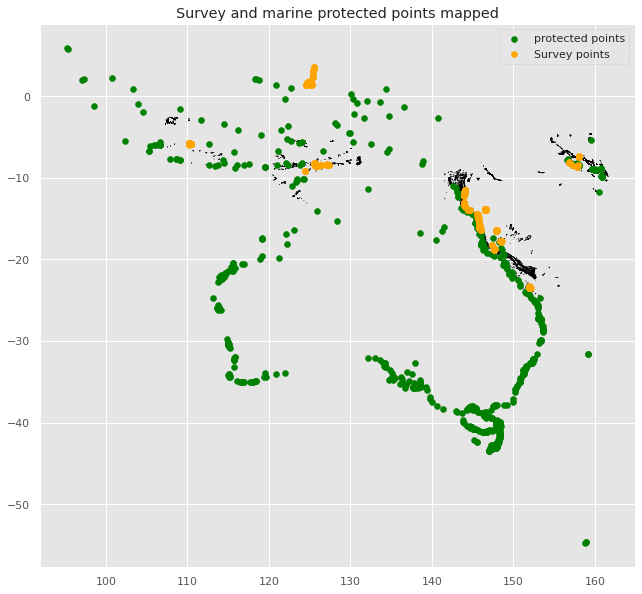

In [15]:
ax = gdf_PAC.plot(edgecolor = "black", figsize  = (20,10), label = "Shapefile");
marine_prot_poly["centroid"].plot(ax = ax, color = "Green")
marine_prot_points.plot(ax = ax, label = "protected points", color = "Green")
df_env.plot(ax = ax, label = "Survey points", color = "orange")
plt.legend();
plt.title("Survey and marine protected points mapped");
marine_prot_poly.rename(columns = {"geometry":"polygon", "centroid":"geometry"}, inplace = True)

In [44]:
marine_prot = pd.concat([marine_prot_poly,marine_prot_points ],ignore_index = True)

In [45]:
# turn multipoint into point
def mult_to_point(df, first_index):
    for ind in range(first_index, len(df)):
        df["geometry"][ind] = Point(df["geometry"][ind][0].x,df["geometry"][ind][0].y)
        
    return df

In [46]:
marine_prot = mult_to_point(marine_prot, 546)

In [47]:
marine_prot.drop(columns = ['WDPAID', 'WDPA_PID', 'PA_DEF', 'NAME', 'ORIG_NAME', 'DESIG',
       'DESIG_ENG', 'DESIG_TYPE', 'IUCN_CAT', 'INT_CRIT', 'MARINE',
       'REP_M_AREA', 'GIS_M_AREA', 'REP_AREA', 'GIS_AREA', 'NO_TAKE',
       'NO_TK_AREA', 'STATUS', 'STATUS_YR', 'GOV_TYPE', 'OWN_TYPE',
       'MANG_AUTH', 'MANG_PLAN', 'VERIF', 'METADATAID', 'SUB_LOC',
       'PARENT_ISO', 'ISO3', 'SUPP_INFO', 'CONS_OBJ', 'polygon'],inplace = True)

In [48]:
# Closest point from marine protected area
dp.swap_coordinates(marine_prot)
marine_prot["geometry"]



0      POINT (-33.316 151.527)
1      POINT (-33.520 151.388)
2      POINT (-18.617 146.495)
3      POINT (-14.670 145.459)
4      POINT (-32.298 133.670)
                ...           
575     POINT (-8.447 157.994)
576     POINT (-5.974 106.693)
577      POINT (-1.170 98.580)
578     POINT (-6.850 115.730)
579     POINT (-5.859 132.571)
Name: geometry, Length: 580, dtype: geometry

In [50]:
df_marine_pro = dp.nearest_neighbor(df_env, marine_prot)

In [52]:
df_env["dist_marine_protection"] = df_marine_pro["distance"]

In [53]:
pop = pd.read_csv("../Data/Anthropological_data/Population_pred/Population-EstimatesData.csv")
pop.drop(columns = ["Unnamed: 95","Indicator Code"], inplace = True)
pop = pop[(pop["Country Code"] == "AUS") | (pop["Country Code"] == "IDN") | (pop["Country Code"] == "TLS")| (pop["Country Code"] == "SLB")]
pop = pop[pop['Indicator Name'].str.contains("Population growth|Population, total")]

In [54]:
pop["Indicator Name"]

9788     Population growth (annual %)
9793                Population, total
24588    Population growth (annual %)
24593               Population, total
40313    Population growth (annual %)
40318               Population, total
43643    Population growth (annual %)
43648               Population, total
Name: Indicator Name, dtype: object

In [55]:
total_pop = pop[pop["Indicator Name"] == "Population, total"].dropna(axis = 1)
total_growth = pop[pop["Indicator Name"] == "Population growth (annual %)"].dropna(axis = 1)

Text(0.5, 1.0, 'Population growth')

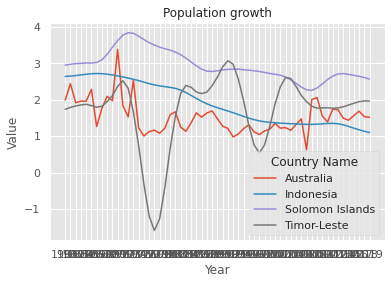

In [56]:
total_growth_melt = total_growth.melt(id_vars=["Country Name", "Country Code", "Indicator Name"], 
        var_name="Year", 
        value_name="Value")
sns.lineplot(x = total_growth_melt["Year"], y = total_growth_melt["Value"], hue = total_growth_melt["Country Name"])
sns.set(rc={'figure.figsize':(13.7,8)})
plt.title("Population growth")

Text(0.5, 1.0, 'Population total')

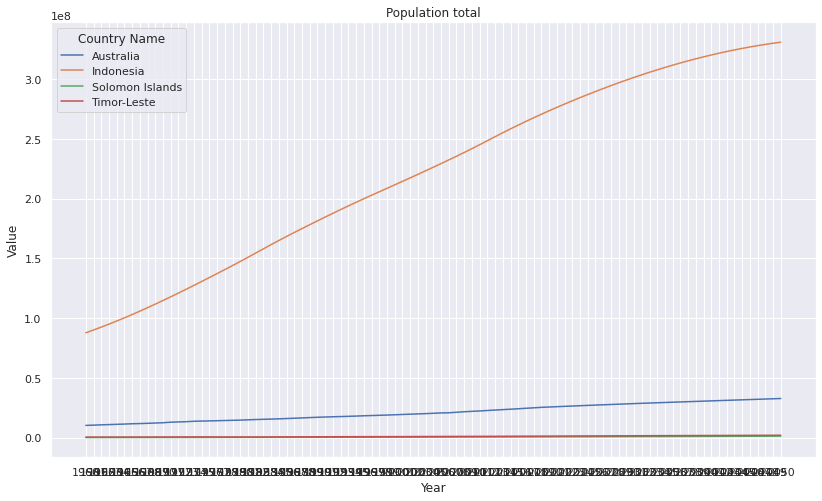

In [57]:
total_pop_melt = total_pop.melt(id_vars=["Country Name", "Country Code", "Indicator Name"], 
        var_name="Year", 
        value_name="Value")
sns.lineplot(x = total_pop_melt["Year"], y = total_pop_melt["Value"], hue = total_pop_melt["Country Name"])
sns.set(rc={'figure.figsize':(13.7,8)})
plt.title("Population total")

In [58]:
total_pop_melt.rename(columns = ({"Country Code": "country", "Year":"year"}), inplace = True)
total_growth_melt.rename(columns = ({"Country Code": "country", "Year":"year"}), inplace = True)

In [59]:
total_pop_melt["year"] = total_pop_melt["year"].astype(int)
total_growth_melt["year"] = total_growth_melt["year"].astype(int)

In [61]:
df_env = pd.merge(df_env,total_pop_melt,on = ["country", "year"]).drop(columns = ["Country Name", "Indicator Name"]).rename(columns = ({"Value":"Population"}))

In [62]:
df_env = pd.merge(df_env,total_growth_melt,on = ["country", "year"]).drop(columns = ["Country Name", "Indicator Name"]).rename(columns = ({"Value":"Population_growth"}))

## Shipping activity

### Land coverage

Only found for Australia..... 

In [31]:
df_env = pd.read_csv("../Data/merged_22_04.csv")
dp.geo_loads(df_env)
df_env = pf.make_geo_frame(df_env)

In [54]:
gLand = gpd.read_file('../Data/Anthropological_data/Land_commodities/CLUM_Commodities_2020.shp')

In [55]:
gLand["centroid"] = gLand["geometry"].centroid

In [56]:
gLand.rename(columns = {"geometry":"polygon", "centroid":"geometry"}, inplace = True)

In [57]:
dp.swap_coordinates(gLand)
gLand["geometry"]

0         POINT (-35.205 148.989)
1         POINT (-35.346 149.151)
2         POINT (-35.313 149.179)
3         POINT (-35.230 149.193)
4         POINT (-35.225 149.195)
                   ...           
146873    POINT (-41.067 147.884)
146874    POINT (-41.075 147.881)
146875    POINT (-40.987 147.312)
146876    POINT (-41.492 146.577)
146877    POINT (-41.149 145.817)
Name: geometry, Length: 146878, dtype: geometry

In [58]:
closest_agr = dp.nearest_neighbor(df_env, gLand)

In [59]:
closest_agr.rename(columns = {"distance":"dist_agr", "Commod_dsc":"agr_type"},inplace = True)

In [78]:
df_env = pd.concat([df_env,closest_agr[["agr_type","Broad_type", "dist_agr"]]], join = "outer", axis = 1)

In [79]:
col_agr = ["agr_type","Broad_type", "dist_agr"]
df_env.loc[df_env['country'] != "AUS", col_agr] = np.nan

In [80]:
df_env.to_csv("../Data/merged_26_04.csv", index = False)

In [3]:

df_env = pd.read_csv("../Data/merged_26_04.csv")
dp.geo_loads(df_env)
df_env = pf.make_geo_frame(df_env)

# Stuck here 27_04

### Global Cover
2009 ESA
300 m resolution


In [7]:
from osgeo import gdal
#Change the following variables to the file you want to convert (inputfile) and
#what you want to name your output file (outputfile).
inputfile = "../Data/Anthropological_data/GlobalCover/GLOBCOVER_L4_200901_200912_V2.3.tif"
outputfile = "../Data/Anthropological_data/GlobalCover/GLOBCOVER.nc"
#Do not change this line, the following command will convert the geoTIFF to a netCDF
ds = gdal.Translate(outputfile, inputfile, format='NetCDF')

KeyboardInterrupt: 

In [3]:
ds_cover = xr.open_dataset("../Data/Anthropological_data/GlobalCover/GLOBCOVER.nc")

In [4]:
# Bounds of coordinates for Pacific
latbounds = [-24, 4]
lonbounds = [110, 160]
lats = ds_cover.variables["lat"][:]
lons = ds_cover.variables["lon"][:]
# latitude lower and upper index
latli = np.argmin( np.abs( lats - latbounds[0] ).values )
latui = np.argmin( np.abs( lats - latbounds[1] ).values ) 
# longitude lower and upper index
lonli = np.argmin( np.abs( lons - lonbounds[0] ).values )
lonui = np.argmin( np.abs( lons - lonbounds[1] ).values )  



In [5]:

# Subset for the given coordinates
Cover_subset = ds_cover.variables['Band1'][latli:latui , lonli:lonui ] 

# Dataset with the chlor amongst the different coordinates
ds_sub_cover = xr.Dataset(data_vars={"Land_type": Cover_subset}, coords = {"lon":ds_cover["lon"][lonli:lonui], "lat": ds_cover["lat"][latli:latui]})



In [6]:
ds_sub_cover_drop = ds_sub_cover.where((ds_sub_cover.Land_type != 210) & (ds_sub_cover.Land_type != 190)  & (ds_sub_cover.Land_type != 220)  & (ds_sub_cover.Land_type != 230))

In [27]:


ds_sub_cover_drop.interpolate_na(dim = "lon", method = "nearest")

<xarray.Dataset>
Dimensions:    (lat: 10080, lon: 18000)
Coordinates:
  * lon        (lon) float64 110.0 110.0 110.0 110.0 ... 160.0 160.0 160.0 160.0
  * lat        (lat) float64 -24.0 -24.0 -23.99 -23.99 ... 3.992 3.994 3.997
Data variables:
    Land_type  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
ds_cover_nearest_

In [19]:
# Set latitude and longitude as index
df_env_ind = df_env.set_index(["lat", "lon"])

In [20]:
# Make a NetCDF with the multi-index dataframe 
xr_merged = xr.Dataset.from_dataframe(df_env_ind)


In [23]:
# Keep interesting lat/long
long_ = [xr_merged["lon"].values]
latg_ = [xr_merged["lat"].values]
df_cover_near = ds_sub_cover_drop.sel(lon=long_[0], lat=latg_[0], method='nearest')


In [24]:
df_cover_near

<xarray.Dataset>
Dimensions:    (lat: 416, lon: 416)
Coordinates:
  * lon        (lon) float64 110.2 110.2 110.2 110.2 ... 158.1 158.1 158.1 158.1
  * lat        (lat) float64 -23.51 -23.51 -23.49 -23.49 ... 3.597 3.6 3.606
Data variables:
    Land_type  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
Cover_same_coord = df_cover_near.assign_coords(lon = long_[0], lat = latg_[0])
xr_merged_Cover = xr_merged.merge(Cover_same_coord, join = "inner")

In [27]:

df_depth_merged = xr_merged_Cover.to_dataframe()
df_depth_merged.head(2)

transectid surveydate  pr_hard_coral  pr_algae  \
lat        lon                                                          
-23.513029 110.181207         NaN        NaN            NaN       NaN   
           110.181230         NaN        NaN            NaN       NaN   

                       pr_soft_coral  pr_oth_invert  pr_other country  \
lat        lon                                                          
-23.513029 110.181207            NaN            NaN       NaN     NaN   
           110.181230            NaN            NaN       NaN     NaN   

                      geometry  wind_speed  ...  closest_port  year  \
lat        lon                              ...                       
-23.513029 110.181207      NaN         NaN  ...           NaN   NaN   
           110.181230      NaN         NaN  ...           NaN   NaN   

                       distance_urban  dist_marine_protection  Population  \
lat        lon                                                              
-23.513029 110.181207             NaN                     NaN         NaN   
           110.181230             NaN                     NaN         NaN   

                       Population_growth  agr_type  Broad_type  dist_agr  \
lat        lon                                                             
-23.513029 110.181207                NaN       NaN         NaN       NaN   
           110.181230                NaN       NaN         NaN       NaN   

                       Land_type  
lat        lon                    
-23.513029 110.181207      210.0  
           110.181230      210.0  

[2 rows x 28 columns]

In [28]:
df_merged = df_depth_merged.dropna().reset_index()

In [29]:
df_merged

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,...,closest_port,year,distance_urban,dist_marine_protection,Population,Population_growth,agr_type,Broad_type,dist_agr,Land_type
0,-23.513029,152.085087,13005.0,2012-11,0.2008,0.6644,0.0464,0.0080,0.0802,AUS,...,603.647480,2012.0,92239.972977,32569.154434,22733465.0,1.745820,mangoes,Fruits,9.087977e+04,210.0
1,-23.512998,152.084493,13005.0,2016-03,0.2455,0.6692,0.0489,0.0171,0.0193,AUS,...,566.574237,2016.0,92194.796986,32512.018359,24190907.0,1.561940,mangoes,Fruits,9.083092e+04,210.0
2,-23.490768,152.095743,41005.0,2016-03,0.1839,0.7929,0.0118,0.0090,0.0023,AUS,...,442.447902,2016.0,94641.653770,32715.830817,24190907.0,1.561940,mangoes,Fruits,9.315336e+04,210.0
3,-23.488319,152.059044,41004.0,2016-03,0.2619,0.5678,0.0822,0.0140,0.0740,AUS,...,210.816516,2016.0,91956.434174,29090.165293,24190907.0,1.561940,mangoes,Fruits,9.023255e+04,210.0
4,-23.473211,151.972529,41002.0,2016-03,0.3040,0.5962,0.0761,0.0220,0.0019,AUS,...,440.474181,2016.0,85432.206546,20277.179996,24190907.0,1.561940,horses,Animals,8.382789e+04,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,3.414524,125.560712,32048.0,2014-10,0.1098,0.7867,0.0076,0.0502,0.0456,IDN,...,509.215999,2014.0,22209.767782,217879.108128,255129004.0,1.310877,sawlogs,Forest,1.713221e+06,40.0
412,3.418516,125.551376,32047.0,2014-10,0.0867,0.6997,0.0085,0.0137,0.1916,IDN,...,224.847496,2014.0,21550.206229,217839.663199,255129004.0,1.310877,sawlogs,Forest,1.713966e+06,170.0
413,3.596443,125.483826,32045.0,2014-10,0.0644,0.8200,0.0052,0.0655,0.0449,IDN,...,580.272068,2014.0,3498.493407,233084.634593,255129004.0,1.310877,sawlogs,Forest,1.735103e+06,210.0
414,3.601132,125.496920,32043.0,2014-10,0.0664,0.6934,0.0030,0.0841,0.1532,IDN,...,364.244619,2014.0,1957.900081,234101.388622,255129004.0,1.310877,sawlogs,Forest,1.735144e+06,210.0


In [8]:
### Night Lights

In [4]:
df_env["year"].value_counts()

2014    162
2012    118
2016     60
2018     41
2017     35
Name: year, dtype: int64

### Fishing

In [4]:
import glob

# Bounds of coordinates for Pacific
latbounds = [-24, 4]
lonbounds = [110, 160]

# 50 km arund survey point I say yes, else no
min_dist = 50000
list_dates_first_part = ["2012", "2014"]
# needs 2016 but crashing
list_dates_second = ["2017", "2018"]




In [10]:
#First part
fishing_dist(df_env, list_dates_first_part)

2012
year 2012 transform done
year 2012 computed distance
year 2012 finished assigning
2014
year 2014 transform done
year 2014 computed distance
year 2014 finished assigning


In [3]:
#df_env.to_csv("../Data/merged_27_04.csv", index = False)
df_env = pd.read_csv("../Data/merged_27_04.csv")
dp.geo_loads(df_env)
df_env = pf.make_geo_frame(df_env)

In [ ]:
# Second part 
fishing_dist(df_env, list_dates_second)

2017
year 2017 transform done
year 2017 made geoDataFrame


In [6]:
import pyproj as proj
def fishing_dist(df_env, list_dates, min_dist = 50000):
    for date in list_dates:
        print(date)
        path = format(f"../Data/Anthropological_data/Fishing/fleet-daily-csvs-100-v2-{date}")
        all_files = glob.glob(path + "/*.csv")
        li = []

        for filename in all_files:
            df = pd.read_csv(filename, index_col=None, header=0)

            df = df[(((df['cell_ll_lon'].between(110,160)) & (df['cell_ll_lat'].between(-24,4)) & (df['fishing_hours'] != 0)))]

            li.append(df)
        frame = pd.concat(li, axis=0, ignore_index=True)
        frame.rename(columns = {"cell_ll_lat":"lat", "cell_ll_lon":"lon"},inplace = True)
        gframe = gpd.GeoDataFrame(
        frame, geometry=gpd.points_from_xy(frame.lat, frame.lon), crs = "WGS84")
        

        # setup your projections
        crs_wgs = proj.Proj(init='epsg:4326') 
        crs_bng = proj.Proj(init='epsg:3112') # use a locally appropriate projected CRS

        # then cast your geographic coordinate pair to the projected system
        x_fish, y_fish = proj.transform(crs_wgs, crs_bng, frame["lon"][:].to_list(), frame["lat"][:].to_list())
        
        print(format(f"year {date} transform done"))
        # First round 
        
        
        x_env, y_env = proj.transform(crs_wgs, crs_bng, df_env["lon"][:].to_list(), df_env["lat"][:].to_list())
        df_env["x"] = x_env
        df_env["y"] = y_env
        genv = df_env.copy()
        genv = gpd.GeoDataFrame(
                    genv, geometry=gpd.points_from_xy(genv.x, genv.y))
            
        frame["x"] = x_fish
        frame["y"] = y_fish
        
        gxframe = gpd.GeoDataFrame(
    frame, geometry=gpd.points_from_xy(frame.x, frame.y))
        print(format(f"year {date} made geoDataFrame"))
        
        df_distance_fishing = genv.geometry.apply(lambda g: gxframe.distance(g))
        print(format(f"year {date} computed distance"))
        dmin = min_dist # 100 km#(df_fi).min().std()
        
        # Fill weight = 1 if within 50km else 0
        df_distance_fishing[~df_distance_fishing[df_distance_fishing < dmin].isnull()] = 1
        df_distance_fishing[df_distance_fishing != 1] = 0
        print(format(f"year {date} finished assigning"))
        
        fish_hours = gxframe["hours"]
        hours_ = df_distance_fishing *fish_hours
        df_env[format(f"fish_hours_{date}")] = hours_.sum(axis = 1)
        
    
    
    
    

<AxesSubplot:>

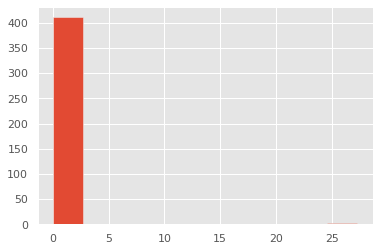

In [118]:
df_env["fishing_hours_2012"].hist()

<AxesSubplot:>

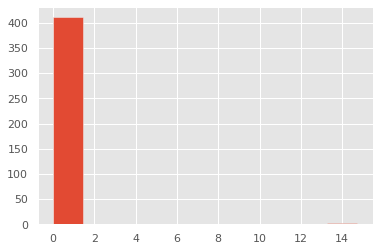

In [119]:
df_env["fishing_hours_2014"].hist()